In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np
import time
from project_utilities import ValueSet, Loss, efficiency
from sklearn.model_selection import train_test_split


In [2]:
train_set_idx, val_set_idx=train_test_split(list(range(1,80)),test_size=15)
len(train_set_idx)

64

In [3]:
DEVICE = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
DEVICE

'cuda:0'

In [5]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [6]:
random_seed= 123
NUM_EPOCHS=4
LEARNING_RATE=0.001
BATCH_SIZE=128

In [7]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)



Mounted at /content/gdrive/


In [8]:
%cd /content/gdrive/MyDrive/data

/content/gdrive/MyDrive/data


In [9]:
class MyDataset(torch.utils.data.Dataset): 
  def __init__(self, setID): 
        'Initialization' 
        npz_files_content = np.load("./Set_"+str(setID)+".npz")  
         
        self.X_set = torch.tensor(npz_files_content['X'])    
        self.y_set = torch.tensor(npz_files_content['y']) 
  def __len__(self): 
        'Denotes the total number of samples' 
        return len(self.y_set) 
  def __getitem__(self, index): 
        'Generates one sample of data' 
        # Select sample 
        X = self.X_set[index] 
        y = self.y_set[index] 
        return X, y

In [10]:
####################################################
##### Training and evaluation wrappers
###################################################
def train(model,num_epochs,learning_rate=0.01, seed=123, batch_size=128):
          
    optimizer= torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)
    # print(1)
    cost = []
    torch.manual_seed(seed)
    for e in range(1,num_epochs):
      # print(2)
      batch_num = 0
      for setID in train_set_idx:
          train_set = MyDataset(setID) # removed + 1
          train_generator = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True,drop_last=True)
          # print(setID)
          for X_train, y_train in train_generator:
            X_train=X_train.to(DEVICE)
            y_train=y_train.to(DEVICE)
            batch_num = batch_num + 1
            #### Compute outputs ####
            yhat = model(X_train)
            # print(3)
            loss = loss_model.forward(yhat, y_train)
            #### Reset gradients from previous iteration ####
            optimizer.zero_grad()
            #### Compute gradients ####
            loss.backward()
            #### Update weights ####
            optimizer.step()
            # print(4)
            #### Logging ####
            with torch.no_grad():
                yhat = model.forward(X_train)
                curr_loss = loss_model.forward(yhat, y_train)
                print('Epoch ID: %d ' % e, end="")
                print('  Set ID: %d' % setID, end="")
                print('  Batch ID: %d' % batch_num, end="")
                print(' | Loss: %.5f' % curr_loss)
                cost.append(curr_loss)
    return cost


In [11]:
class Trim(torch.nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :4, :4000]
class Reshape(torch.nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)   
          

In [12]:
class CONVAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential( #784
                nn.Conv2d(1, 4, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(4, 6, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(6, 6, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(6, 8, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
                nn.Linear(8000, 64)
        )
        self.decoder = nn.Sequential(
                torch.nn.Linear(64, 8000),
                Reshape(-1, 8, 1, 1000),
                nn.ConvTranspose2d(8, 6, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(6, 6, stride=(2, 2), kernel_size=(3, 3), padding=1),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(6, 4, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(4, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(), 
                torch.nn.Conv2d(1, 2, kernel_size=3, padding="same"),
                torch.nn.Dropout2d(0.3),
                torch.nn.ReLU(inplace=True),
                torch.nn.BatchNorm2d(2),
                torch.nn.MaxPool2d(kernel_size=2),
                torch.nn.Conv2d(2,3, kernel_size=3, padding="same"),
                torch.nn.Dropout2d(0.3),
                torch.nn.ReLU(inplace=True),
                torch.nn.BatchNorm2d(3),
                torch.nn.MaxPool2d(kernel_size=2),
                torch.nn.Conv2d(3,4, kernel_size=3, padding="same"),
                torch.nn.ReLU(inplace=True),
        
                torch.nn.Flatten()
                )

    def forward(self, x):
        n,h,w=x.shape
        x=x.view(n,1,h,w)
        # print(x.shape)
        x = self.encoder(x)
        # print(x.shape)
        x = self.decoder(x)
        # print(x.shape)
        return x

In [13]:
model=CONVAE()
model=model.to(DEVICE)

loss_model = Loss(0.00001)
cost = train(model,
             num_epochs=NUM_EPOCHS,
             learning_rate=LEARNING_RATE,
             seed=random_seed, batch_size=BATCH_SIZE)

Streaming output truncated to the last 5000 lines.
Epoch ID: 1   Set ID: 49  Batch ID: 2489 | Loss: 0.09441
Epoch ID: 1   Set ID: 49  Batch ID: 2490 | Loss: 0.10048
Epoch ID: 1   Set ID: 49  Batch ID: 2491 | Loss: 0.09119
Epoch ID: 1   Set ID: 49  Batch ID: 2492 | Loss: 0.09694
Epoch ID: 1   Set ID: 49  Batch ID: 2493 | Loss: 0.09440
Epoch ID: 1   Set ID: 49  Batch ID: 2494 | Loss: 0.09570
Epoch ID: 1   Set ID: 49  Batch ID: 2495 | Loss: 0.09858
Epoch ID: 1   Set ID: 49  Batch ID: 2496 | Loss: 0.09364
Epoch ID: 2   Set ID: 34  Batch ID: 1 | Loss: 0.10067
Epoch ID: 2   Set ID: 34  Batch ID: 2 | Loss: 0.09445
Epoch ID: 2   Set ID: 34  Batch ID: 3 | Loss: 0.09874
Epoch ID: 2   Set ID: 34  Batch ID: 4 | Loss: 0.09899
Epoch ID: 2   Set ID: 34  Batch ID: 5 | Loss: 0.10114
Epoch ID: 2   Set ID: 34  Batch ID: 6 | Loss: 0.09938
Epoch ID: 2   Set ID: 34  Batch ID: 7 | Loss: 0.09864
Epoch ID: 2   Set ID: 34  Batch ID: 8 | Loss: 0.09396
Epoch ID: 2   Set ID: 34  Batch ID: 9 | Loss: 0.10281
Epoch I

In [14]:
a=torch.tensor(cost)
cost1=a.cpu().numpy()

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

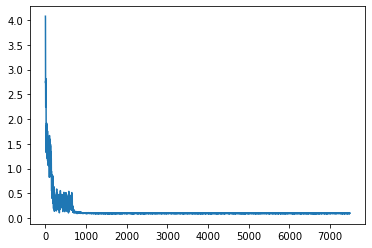

In [16]:
plt.plot(cost1)

In [17]:
def validate(model): 
  
    loss_val = [] 
    eff = ValueSet(0, 0, 0, 0) 
    # switch to evaluate mode 
    model.eval() 
    with torch.no_grad():
        for setID in val_set_idx: 
          val_set = MyDataset(setID+1) 
          val_generator = torch.utils.data.DataLoader(val_set,  
                                                      batch_size=5000,  
                                                      shuffle=True) 
          print(setID) 
          for X_val, y_val in val_generator: 
            X_val=X_val.to(DEVICE)
            y_val=y_val.to(DEVICE)
            # Forward pass 
            val_outputs = model(X_val) 
            loss_output = loss_model.forward(val_outputs, y_val) 
            loss_val.append(loss_output) 
            for label, output in zip(y_val.cpu().numpy(), val_outputs.cpu().numpy()):
                eff += efficiency(label, output, difference = 5.0,  
                                  threshold = 1e-2, integral_threshold = 0.2,  
                                  min_width = 3) 
    return sum(loss_val)/len(loss_val), eff.eff_rate, eff.fp_rate

In [18]:
loss_val, eff_rate, fp_rate = validate(model) 
print('Loss: %0.3f ' % loss_val, end="")
print('  Efficiency: %0.3f' % eff_rate, end="") 
print('  False positive rate: %0.3f' % fp_rate) 


35
75
51
68
8
15
70
7
55
43
60
58
63
3
44
Loss: 0.096   Efficiency: 0.000  False positive rate: 0.000


In [19]:
model.eval()

CONVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(4, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(6, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=8000, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=8000, bias=True)
    (1): Reshape()
    (2): ConvTranspose2d(8, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(6, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(6, 4, kernel_size=(3, 3), stride=(2, 2))
    (7): LeakyReLU(negative_slo

In [20]:
def train(model,train_set_idx, num_epochs,
          learning_rate=0.01, seed=123, batch_size=128):
    cost = []
    
    torch.manual_seed(seed)
    
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    
    for e in range(1,num_epochs):
      batch_num = 0
      for setID in train_set_idx:
          train_set = MyDataset(setID+1)
          train_generator = torch.utils.data.DataLoader(train_set, 
                                                        batch_size=batch_size, 
      shuffle=True)
          print(setID)
          for X_train, y_train in train_generator:
            X_train=X_train.to(DEVICE)
            y_train=y_train.to(DEVICE)
            batch_num = batch_num + 1
            #### Compute outputs ####
            yhat = model(X_train)
            loss = loss_model.forward(yhat, y_train)
            optimizer.zero_grad()
            
            #### Compute gradients ####
            loss.backward()
            
            #### Update weights ####
            optimizer.step()
            #### Logging ####
            with torch.no_grad():
                yhat = model.forward(X_train)
                curr_loss = loss_model.forward(yhat, y_train)
                cost.append(curr_loss)
    return cost

In [21]:
def validate(model,val_set_idx):
    loss_val = []
    eff = ValueSet(0, 0, 0, 0)
    # switch to evaluate mode
    model.eval()
    with torch.no_grad():
        for setID in val_set_idx:
          val_set = MyDataset(setID+1)
          val_generator = torch.utils.data.DataLoader(val_set, 
                                                      batch_size=1024, 
    shuffle=True)
          # print(setID)
          for X_val, y_val in val_generator:
            X_val=X_val.to(DEVICE)
            y_val=y_val.to(DEVICE)
            # Forward pass
            val_outputs = model(X_val)
            loss_output = loss_model.forward(val_outputs, y_val)
            loss_val.append(loss_output)
            for label, output in zip(y_val.cpu().numpy(), val_outputs.cpu().numpy()):
                eff += efficiency(label, output, difference = 5.0, 
                                  threshold = 1e-2, integral_threshold = 0.2, 
                                  min_width = 3)
    return sum(loss_val)/len(loss_val), eff.eff_rate, eff.fp_rate

In [24]:
a=[15,24,40,50]
train_cost=[]
test_cost=[]
for i in a:
  train_set_idx, val_set_idx=train_test_split(list(range(1,80)),test_size=i)
  torch.manual_seed(123)
  model=CONVAE()
  model=model.to(DEVICE)

  loss_model = Loss(0.00001)
  cost = train(model,train_set_idx,
             num_epochs=3,
             learning_rate=LEARNING_RATE,
             seed=random_seed, batch_size=BATCH_SIZE)
  b=torch.tensor(cost)
  cost1=b.cpu().numpy()
  train_cost.append(cost1[-1])
  loss_val, eff_rate, fp_rate = validate(model,val_set_idx)
  loss_test=loss_val.cpu().numpy()
  loss_test
  test_cost.append(loss_test)

40
53
23
54
11
74
32
29
70
4
3
65
24
72
51
66
34
45
14
21
41
26
55
17
1
6
71
25
52
56
9
30
46
36
69
58
59
78
49
5
47
20
27
8
33
38
7
15
37
60
31
16
68
50
22
43
35
61
75
76
10
67
18
79
40
53
23
54
11
74
32
29
70
4
3
65
24
72
51
66
34
45
14
21
41
26
55
17
1
6
71
25
52
56
9
30
46
36
69
58
59
78
49
5
47
20
27
8
33
38
7
15
37
60
31
16
68
50
22
43
35
61
75
76
10
67
18
79
17
40
2
35
18
34
3
32
14
75
62
25
72
23
78
69
49
44
28
73
57
58
50
63
27
51
77
29
67
37
53
1
45
30
19
59
20
64
16
39
61
5
8
68
10
54
43
52
55
76
46
79
74
11
26
17
40
2
35
18
34
3
32
14
75
62
25
72
23
78
69
49
44
28
73
57
58
50
63
27
51
77
29
67
37
53
1
45
30
19
59
20
64
16
39
61
5
8
68
10
54
43
52
55
76
46
79
74
11
26
48
33
60
16
71
1
27
62
51
77
36
23
18
53
7
78
8
63
30
79
4
66
49
68
59
22
56
11
26
25
76
14
65
6
58
55
21
75
61
48
33
60
16
71
1
27
62
51
77
36
23
18
53
7
78
8
63
30
79
4
66
49
68
59
22
56
11
26
25
76
14
65
6
58
55
21
75
61
11
18
71
28
54
43
75
19
57
12
46
4
61
29
21
55
77
70
79
40
66
33
34
22
26
6
42
9
1
11
18

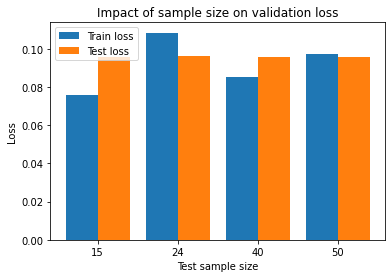

In [25]:
X = ['15','24','40','50']
f = train_cost
g = test_cost
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, f, 0.4, label = 'Train loss')
plt.bar(X_axis + 0.2, g, 0.4, label = 'Test loss')
  
plt.xticks(X_axis, X)
plt.xlabel("Test sample size")
plt.ylabel("Loss")
plt.title("Impact of sample size on validation loss")
plt.legend()
plt.show()